In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from os.path import join, exists
from tqdm import tqdm

import pandas as pd
import numpy as np
import random
import pickle
import glob
import json
import yaml
import time
import re
import os

from multiprocessing import Pool, cpu_count

from holodecml.vae.checkpointer import *
from holodecml.vae.optimizers import *
from holodecml.vae.tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import *
import torch.nn.functional as F
from torch import nn
import torch

import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


### Load the configuration

In [3]:
with open("results/9_23/pandas/config_experiment.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

In [4]:
class LoadGeckoData:
    
    def __init__(self, 
                 data_path,
                 save_path,
                 summary_file,  
                 bin_prefix = [], 
                 input_vars = [],
                 output_vars = [],
                 seq_length = 1, 
                 num_timesteps = 1439,
                 experiment_subset = [],
                 cached_dir = "./",
                 shuffle = True,
                 scaler_x = None,
                 scaler_y = None, 
                 fit = False, 
                 *args, **kwargs):
        
        self.path = data_path
        self.save_path = save_path
        self.summary_file = summary_file
        self.experiment_subset = experiment_subset
        self.cached_dir = cached_dir
        self.bin_prefix = bin_prefix
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.seq_length = 1
        self.num_timesteps = num_timesteps
        
        self.shuffle = shuffle
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
        self.fit = fit
        
        self.load()
        self.on_epoch_end()
        
        self.reshape = True
        if any([self.scaler_x is None, self.scaler_y is None]) or self.fit:
            self.fit_scalers()
            
    def load(self):
        file_list = glob.glob(os.path.join(self.path, 'ML2019_*'))
        self.file_list = sorted(file_list, key = lambda x: int(x.split("Exp")[1].strip(".csv")))
        self.summary_file = pd.read_csv(
            os.path.join(self.path, self.summary_file), skiprows = 3
        )
        self.summary_file.columns = [x.strip() for x in self.summary_file.columns]
    
    def get_transform(self):
        return self.scaler_x, self.scaler_y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.experiment_subset)
    
    def __getitem__(self, idx):
        'Generate one data point'
        
        ### Find the relevant experiment file 
        exp = self.experiment_subset[idx]
        
        ### If we have this experiment already cached, load it
        cached = f"{self.cached_dir}/{exp}.pkl"
        if os.path.isfile(cached) and self.scaler_x is not None:
            with open(cached, "rb") as fid:
                return pickle.load(fid)
        
        ### Else we have to create it for the first time.
        for file_path in self.file_list:
            if f"Exp{exp}" in file_path:
                break

        ### Load the experiment file
        df = pd.read_csv(file_path)
        df.columns = [x.strip() for x in df.columns]

        ### Load the summary file
        exp_num = int(re.findall("_Exp(\d+)*", file_path)[0])
        summary_file = self.summary_file[(
            self.summary_file['id'] == f"Exp{exp_num}"
        )].copy()

        for variable in summary_file.columns:
            df[variable] = summary_file[variable][exp_num]

        if len(self.bin_prefix) > 0: 
            for prefix in self.bin_prefix:
                df[prefix] = df.loc[:, df.columns.str.contains(prefix, regex=False)].sum(axis=1)

        df = self.add_diurnal_signal(df)
                
        input_subset = df[self.input_vars].iloc[:-1,:].copy()
        output_subset = df[self.output_vars].iloc[1:,:].copy()

        if "index" in input_subset.columns:
            input_subset = input_subset.drop(columns = ["index"])
        if "index" in output_subset.columns:
            output_subset = output_subset.drop(columns = ["index"])

        #input_subset = self.add_diurnal_signal(input_subset)
        #output_subset = self.add_diurnal_signal(output_subset)

        self.processed += 1
        if self.processed == self.__len__():
            self.on_epoch_end()

        if self.scaler_x is not None:
            input_subset = self.scaler_x.transform(
                input_subset.drop(['Time [s]', 'id'], axis=1)
            )
        if self.scaler_y is not None:
            output_subset = self.scaler_y.transform(
                output_subset.drop(['Time [s]', 'id'], axis=1)
            )
        if self.reshape:
            input_subset, output_subset = self.reshape_data(input_subset, output_subset)
            
            with open(cached, "wb") as fid:
                pickle.dump([input_subset, output_subset], fid)

        return input_subset, output_subset
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.processed = 0
        if self.shuffle == True:
            random.shuffle(self.file_list)
            
    def add_diurnal_signal(self, x_data):
        """
        Apply Function to static temperature to add +- 4 [K] diurnal signal (dependent of time [s] of timeseries).
        Args:
            x_data: Pre-scaled/normalized input data (Pandas DF).

        Returns: Same df with function applied to temperature feature.
        """
        x_data['temperature (K)'] = x_data['temperature (K)'] + 4.0 * np.sin(
            (x_data['Time [s]'] * 7.2722e-5 + (np.pi / 2.0 - 7.2722e-5 * 64800.0)))

        return x_data
    
    def get_tendencies(self, df):
        """
         Transform dataframe to time tendencies rather than actual values. Preserves static environmental values.
        Args:
            df: Pre-scaled input dataframe.
            input_cols: Input columns to be transformed (should include 'id' and 'Time' for indexing).
        Returns: Pandas dataframe with input columns transformed to tendencies (Removes the first sample of each Exp).
        """
        df_copy = df.copy()
        dummy_df = df[self.output_vars].drop(['Time [s]'], axis=1).groupby('id').diff().reset_index(drop=True)
        df_copy[self.output_vars[1:-1]] = dummy_df.values
        df_copy.loc[:, ~df_copy.columns.isin(self.output_vars)] = df.loc[:, ~df.columns.isin(self.output_vars)]
        dff = df_copy.groupby('id').apply(lambda x: x.iloc[1:, :]).reset_index(drop=True)
        return dff
    
    def fit_scalers(self):

        filepath = os.path.join(self.save_path, "scalers.pkl")
        
        if os.path.isfile(filepath) and not self.fit:
            #logging.info(f"Loading data preprocessing models from {filepath}")
            with open(filepath, "rb") as fid:
                self.num_timesteps, self.scaler_x, self.scaler_y = pickle.load(fid)
            
        else:
            #logging.info("Fitting data preprocessing models: QuantileTransformer")
            self.reshape = False                    
            with Pool(24) as p:
                xs, ys = zip(*[(x,y) for (x,y) in tqdm(
                    p.imap(self.__getitem__, range(len(self.experiment_subset))),
                    total = len(self.experiment_subset))
                ])
            p.join()
            p.close()                    
                    
            xs = pd.concat(xs)
            ys = pd.concat(ys)
            self.reshape = True
            
            self.num_timesteps = xs['Time [s]'].nunique()

            self.scaler_x = Pipeline(
                steps=[('quant', QuantileTransformer()), ('minmax', MinMaxScaler((0, 1)))]
            )
            self.scaler_y = Pipeline(
                steps=[('quant', QuantileTransformer()), ('minmax', MinMaxScaler((0, 1)))]
            )
            
            scaled_in_train = self.scaler_x.fit_transform(
                xs.drop(['Time [s]', 'id'], axis=1)
            )
            scaled_out_train = self.scaler_y.fit_transform(
                ys.drop(['Time [s]', 'id'], axis=1)
            )

            with open(filepath, "wb") as fid:
                pickle.dump([self.num_timesteps, self.scaler_x, self.scaler_y], fid)
            #logging.info("Saved data preprocessing models to {filepath}")
            
    def reshape_data(self, x_data, y_data):
        """
        Reshape matrix data into sample shape for LSTM training.

        Args:
            x_data: DataFrame containing input features (columns) and time steps (rows).
            y_data: Matrix containing output features (columns) and time steps (rows).
            seq_length: Length of look back time steps for one time step of prediction.
            num_timesteps: Number of time_steps per experiment.

        Returns: Two np.ndarrays, the first of shape (samples, length of sequence,
            number of features), containing the input data for the LSTM. The second
            of shape (samples, number of output features) containing the expected output for each input
            sample.
        """

        x_data = torch.from_numpy(x_data.astype(np.float32))
        y_data = torch.from_numpy(y_data.astype(np.float32))
                
        return x_data, y_data

### Create the train, test, val splits

In [5]:
random.seed(5000)

In [6]:
file_list = glob.glob(os.path.join(config["data"]["data_path"], 'ML2019_*'))
file_list = sorted(file_list, key = lambda x: int(x.split("Exp")[1].strip(".csv")))

In [7]:
experiments = []
for x in file_list:
    x = int(x.split("Exp")[1].strip(".csv"))
    if x >= config["data"]["min_exp"] and x <= config["data"]["max_exp"]:
        experiments.append(x)

# train_split, _test = train_test_split(experiments, test_size = 0.2)
# valid_split, test_split = train_test_split(_test, test_size = 0.5)

In [8]:
# train_split = train_split[:128]
# valid_split = valid_split[:128]
# test_split = test_split[:128]

In [9]:
with open("clustered/experiment_data/experiment_train_test_val_splits.pkl", "rb") as fid:
    train_split, valid_split, test_split = pickle.load(fid)

In [10]:
cached_data = glob.glob(config["data"]["cached_dir"] + "/*pkl")
if len(cached_data):
    fit = False
else:
    fit = True

train_data_set = LoadGeckoData(
    **config["data"],
    experiment_subset = train_split,
    shuffle = True,
    fit = fit
)

In [11]:
#train_data_set.experiment_ids
x, y = train_data_set.__getitem__(20)

In [12]:
x.shape

torch.Size([1439, 35])

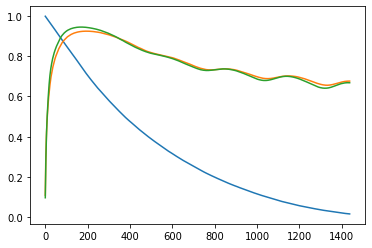

In [13]:
plt.plot(range(y.shape[0]), y[:, 0])
plt.plot(range(y.shape[0]), y[:, 1])
plt.plot(range(y.shape[0]), y[:, 2])

In [14]:
valid_data_set = LoadGeckoData(
    **config["data"],
    num_timesteps = train_data_set.num_timesteps,
    experiment_subset = valid_split,
    shuffle = False,
    scaler_x = train_data_set.scaler_x,
    scaler_y = train_data_set.scaler_y 
)

In [15]:
test_data_set = LoadGeckoData(
    **config["data"],
    num_timesteps = train_data_set.num_timesteps,
    experiment_subset = test_split,
    shuffle = False,
    scaler_x = train_data_set.scaler_x,
    scaler_y = train_data_set.scaler_y 
)

### Initialize iterators

In [16]:
#logging.info(f"Loading training data iterator using {config['iterator']['num_workers']} workers")
    
train_dataloader = DataLoader(
    train_data_set,
    **config["iterator"]
)

config["iterator"]["batch_size"] = len(valid_split)

valid_dataloader = DataLoader(
    valid_data_set,
    **config["iterator"]
)

test_dataloader = DataLoader(
    test_data_set,
    **config["iterator"]
)

### Model

In [17]:
class DenseNet(nn.Module):

    def __init__(self, 
                 input_size, 
                 output_size, 
                 hidden_dims = [100, 50], 
                 dropouts = [0.2, 0.2]):
        
        super(DenseNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        #self.embedding = nn.Embedding(train_data_set.num_timesteps, 16)
        
        self.model = [
            nn.Linear(input_size, hidden_dims[0]),
            nn.BatchNorm1d(num_features=hidden_dims[0]),
            nn.LeakyReLU()
        ]
        if len(hidden_dims) > 1:
            if dropouts[0] > 0.0:
                self.model.append(nn.Dropout(dropouts[0]))
            for i in range(len(hidden_dims)-1):
                self.model.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
                self.model.append(nn.BatchNorm1d(num_features=hidden_dims[i+1]))
                self.model.append(nn.LeakyReLU())
                if dropouts[i+1] > 0.0:
                    self.model.append(nn.Dropout(dropouts[i+1]))
        self.model.append(nn.Linear(hidden_dims[-1], output_size))
        self.model.append(nn.Sigmoid())
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        #x1, x2 = x
        #x1 = self.embedding(x1)
        #x = torch.cat([x1, x2], 1)
        x = self.model(x)
        return x

In [18]:
model = DenseNet(**config["model"])

In [19]:
model

DenseNet(
  (model): Sequential(
    (0): Linear(in_features=35, out_features=10000, bias=True)
    (1): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=10000, out_features=29, bias=True)
    (4): Sigmoid()
  )
)

In [21]:
if is_cuda:
    model = model.to(device)

In [22]:
optimizer = LookaheadDiffGrad(model.parameters(),
                              lr=config["optimizer"]["lr"])
                              #weight_decay=1e-5)

In [23]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat,y))
    
class R2Score(nn.Module):

    def forward(self, y_pred, y):
        _num_examples = y.shape[1]
        _sum_of_errors = torch.sum(torch.pow(y_pred - y, 2))
        _y_sum = torch.sum(y)
        _y_sq_sum = torch.sum(torch.pow(y, 2))
        return _sum_of_errors / (_y_sq_sum - (_y_sum ** 2) / _num_examples)

In [24]:
# # Measure allocated memory after the call
# torch.cuda.synchronize()
# end_max_memory = torch.cuda.max_memory_allocated() / 1024**2
# end_memory = torch.cuda.memory_allocated() / 1024**2

class BaseTrainer:
    
    def __init__(self, 
                 model, 
                 optimizer,
                 train_gen, 
                 valid_gen, 
                 dataloader, 
                 valid_dataloader,
                 start_epoch = 0,
                 epochs = 100,
                 window_size = 10,
                 teacher_force = True,
                 gamma = 0.5,
                 device = "cpu",
                 clip = 1.0,
                 path_save = "./"):
        
        self.model = model
        self.outsize = model.output_size
        self.optimizer = optimizer
        self.train_gen = train_gen
        self.valid_gen = valid_gen
        self.dataloader = dataloader
        self.valid_dataloader = valid_dataloader
        self.batch_size = dataloader.batch_size
        self.path_save = path_save
        self.device = device
        
        self.start_epoch = start_epoch 
        self.epochs = epochs
        self.window_size = window_size
        
        self.teacher_force = teacher_force
        self.gamma = gamma
        
        #self.criterion = nn.MSELoss()
        
        timesteps = self.train_gen.num_timesteps
        self.time_range = list(range(timesteps))
                
        # Gradient clipping through hook registration
        for p in self.model.parameters():
            p.register_hook(lambda grad: torch.clamp(grad, -clip, clip))
        logger.info(f"Clipping gradients to range [-{clip}, {clip}]")
        
        # Create the save directory if it does not exist
        try:
            os.makedirs(path_save)
        except:
            pass
        
    def criterion(self, y_true, y_pred):
        
        y_true_precursor = y_true[:, :, 0]
        y_pred_precursor = y_pred[:, :, 0]
        
        y_true_gas = y_true[:, :, 1:15]
        y_pred_gas = y_pred[:, :, 1:15]
        
        y_true_aero = y_true[:, :, 15:]
        y_pred_aero = y_pred[:, :, 15:]
        
        mse_precursor = nn.MSELoss()(y_true_precursor, y_pred_precursor)
        mse_gas = nn.MSELoss()(y_true_gas, y_pred_gas)
        mse_aero = nn.MSELoss()(y_true_aero, y_pred_aero)
        mse = mse_precursor + mse_gas + mse_aero
        
        kld_gas = nn.KLDivLoss()(
            F.log_softmax(y_pred_gas),
            F.softmax(y_true_gas)
        )
        kld_aero = nn.KLDivLoss()(
            F.log_softmax(y_pred_aero),
            F.softmax(y_true_aero)
        )
        return mse + (kld_gas + kld_aero)
        
    def train_one_epoch(self, epoch, steps = 1e10):
        
        self.model.train()
        batches_per_epoch = int(np.ceil(self.train_gen.__len__() / self.batch_size))
        batch_group_generator = tqdm(
            self.dataloader,
            total=batches_per_epoch, 
            leave=True
        )
        
#         if epoch == 0:
#             self.idx = 0
#         else:
#             self.idx += 1 
#         self.window = self.time_range[self.idx * self.window_size : (self.idx + 1) * self.window_size]
        
#         if len(self.window) == 0:
#             self.idx = 0
#             self.window = self.time_range[self.idx * self.window_size : (self.idx + 1) * self.window_size]
            
        #self.window = self.time_range[0:(self.idx * self.window_size)]
        self.window = self.time_range #[:self.window_size]
    
        epoch_losses = {"loss": []}
        for batch_idx, (x, y) in enumerate(batch_group_generator):
            x = x.to(device)
            y = y.to(device)

#             self.window = random.choice(self.time_range)
#             if self.window_size > 0:
#                 self.window = [self.window + (i+1) for i in range(self.window_size)]
#             else:
#                 self.window = [self.window]
#             self.window = [x for x in self.window if x <= max(self.time_range)]
            #window = random.sample(self.time_range, self.window_size) # only works when forcing = 1.0
                        
            y_true, y_pred, weights = [], [], []
            for i in range(y.size(1)):
                next_x = self.model(x[:,i,:])
                y_true.append(y[:, i])
                y_pred.append(next_x)                                
                if i < (y.size(1)-1):
                    if (epoch == self.epochs - 1) or (not self.teacher_force):
                        x = x.clone()
                        x[:, i+1, :self.outsize] = next_x                        
                    else:
                        cost = self.tf_annealer(epoch) 
                        idx = [bn for bn in range(x.size(0)) if cost < random.random()]
                        if len(idx) > 0:
                            x = x.clone() # next line is in-place op, messes up grad. comp. 
                            x[idx, i+1, :self.outsize] = next_x[idx]  
                            
            y_true = torch.stack(y_true).permute(1,0,2)
            y_pred = torch.stack(y_pred).permute(1,0,2)
            loss = self.criterion(y_true, y_pred)   
            epoch_losses["loss"].append(loss.item())

            # backprop after experiment
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # update tqdm
            to_print = "loss: {:.3f}".format(np.mean(epoch_losses["loss"]))
            batch_group_generator.set_description(to_print)
            batch_group_generator.update()
            
#             if batch_idx % steps == 0:
#                 break
            
        return np.mean(epoch_losses["loss"])
            
    def test(self, epoch):

        self.model.eval()
        batches_per_epoch = int(np.ceil(self.valid_gen.__len__() / self.batch_size))

        with torch.no_grad():

            batch_group_generator = tqdm(
                self.valid_dataloader,
                total=batches_per_epoch, 
                leave=True
            )
            
            epoch_losses = {"loss": []}
            for (x, y) in batch_group_generator:
                x = x.to(device)
                y = y.to(device)
                y_true, y_pred = [], []
                for i in range(y.size(1)):
                    next_x = self.model(x[:,i,:])
                    y_true.append(y[:, i])
                    y_pred.append(next_x)
                    if i < (y.shape[1]-1):
                        x[:, i+1, :self.outsize] = next_x # never "force" on eval
                y_true = torch.stack(y_true).permute(1,0,2)
                y_pred = torch.stack(y_pred).permute(1,0,2)
                loss = self.criterion(y_true, y_pred)
                epoch_losses["loss"].append(loss.item())

                # update tqdm
                to_print = "val_loss: {:.3f}".format(np.mean(epoch_losses["loss"]))
                batch_group_generator.set_description(to_print)
                batch_group_generator.update()
            
        return np.mean(epoch_losses["loss"]) 
    
    
    def train(self,
              scheduler,
              early_stopping,
              metrics_logger):
        
        logger.info(
            f"Training the model for up to {self.epochs} epochs starting at epoch {self.start_epoch}"
        )
        
        flag = isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)
        
        for epoch in range(self.start_epoch, self.epochs):
            train_loss = self.train_one_epoch(epoch)
            test_loss = self.test(epoch)

            scheduler.step(test_loss if flag else epoch)
            early_stopping(epoch, test_loss, self.model, self.optimizer)

            # Write results to the callback logger 
            result = {
                "epoch": epoch,
                "train_loss": train_loss,
                "valid_loss": test_loss,
                "lr": early_stopping.print_learning_rate(self.optimizer),
                "teacher_forcing_score": self.tf_annealer(epoch) if self.teacher_force else 1.0
            }
            metrics_logger.update(result)

            if early_stopping.early_stop:
                logger.info("Early stopping")
                break

    def tf_annealer(self, epoch):
        return 1.0 * self.gamma ** epoch # 1/(1 + self.decay * epoch) 

In [25]:
trainer = BaseTrainer(
    model, 
    optimizer,
    train_data_set, 
    valid_data_set, 
    train_dataloader, 
    valid_dataloader,
    device = device,
    **config["trainer"]
)

In [26]:
# Initialize LR annealing scheduler 
if "ReduceLROnPlateau" in config["callbacks"]:
    schedule_config = config["callbacks"]["ReduceLROnPlateau"]
    scheduler = ReduceLROnPlateau(trainer.optimizer, **schedule_config)
    #logging.info(
    #    f"Loaded ReduceLROnPlateau learning rate annealer with patience {schedule_config['patience']}"
    #)
elif "ExponentialLR" in config["callbacks"]:
    schedule_config = config["callbacks"]["ExponentialLR"]
    scheduler = ExponentialLR(trainer.optimizer, **schedule_config)
    #logging.info(
    #    f"Loaded ExponentialLR learning rate annealer with reduce factor {schedule_config['gamma']}"
    #)

# Early stopping
checkpoint_config = config["callbacks"]["EarlyStopping"]
early_stopping = EarlyStopping(**checkpoint_config)

# Write metrics to csv each epoch
metrics_logger = MetricsLogger(**config["callbacks"]["MetricsLogger"])

In [27]:
#torch.autograd.set_detect_anomaly(True)

In [ ]:
trainer.train(scheduler, early_stopping, metrics_logger)

loss: 0.173:  58%|█████▊    | 463/800 [05:37<03:58,  1.41it/s]

### Predict with the best model

In [ ]:
with open("clustered/config.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

In [ ]:
model = DenseNet(**config["model"])

In [ ]:
model_dict = torch.load("results/9_23/pandas/best.pt", 
                        map_location=lambda storage, loc: storage)

In [ ]:
model.load_state_dict(model_dict["model_state_dict"])
#model.eval()

In [ ]:
# if is_cuda:
#     model = model.to(device)
device = "cpu"
model = model.to(device)

In [ ]:
for (x, y) in test_dataloader:
    x = x.to(device)
    y = y.to(device)
    break

In [ ]:
loss = []
preds = []
for t in tqdm(range(y.shape[1])):
    next_x = model(x[:,t,:])
    preds.append(next_x)
    #loss.append(RMSELoss()(next_x, y[:,t]))
    
    #if t < (y.shape[1]-1):
    #    x[:, t+1, :model.output_size] = next_x # never force on test

#loss = torch.mean(torch.stack(loss))
preds = torch.stack(preds, axis = -1).permute(0, 2, 1)

In [ ]:
nsteps = y.shape[1]

plt.plot(range(nsteps), y[1, :nsteps, 0])
plt.plot(range(nsteps), y[1, :nsteps, 1:15].sum(-1)/14)
plt.plot(range(nsteps), y[1, :nsteps, 15:].sum(-1)/14)

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.ylim([0.0, 1.01])

In [ ]:
plt.plot(range(nsteps), preds[1, :nsteps, 0].detach().numpy())
plt.plot(range(nsteps), preds[1, :nsteps, 1:15].detach().numpy().sum(-1)/14)
plt.plot(range(nsteps), preds[1, :nsteps, 15:].detach().numpy().sum(-1)/14)

plt.ylabel("Precursor/Gas/Aerosol")
plt.xlabel("Time steps")

plt.ylim([0.0, 1.01])

In [ ]:
nn.MSELoss()(y[:,:nsteps,:], preds[:, :nsteps, :])

In [ ]:
nn.KLDivLoss()(
    F.log_softmax(preds[:, :nsteps, 1:15]), 
    F.softmax(y[:, :nsteps, 1:15])
)

In [ ]:
nn.KLDivLoss()(
    F.log_softmax(preds[:, :nsteps, 15:]), 
    F.softmax(y[:, :nsteps, 15:])
)